In [1]:
import nasdaqdatalink
import numpy as np
import pandas as pd
import re


Input:
Tickers,Weights

In [91]:
tickers=['SPX','AAPL','MSFT','AMZN']
weights=[-1,1/3,1/3,1/3]

In [3]:
class nasdaq_helper:
    def __init__(self):
        pass
    @staticmethod
    def convert_tickers_to_nasdaq(tickers):
        result=["OPT/"+ticker for ticker in tickers]
        return result
    

In [4]:
opt_tick=nasdaq_helper.convert_tickers_to_nasdaq(tickers)
opt_tick

['OPT/SPX', 'OPT/AAPL', 'OPT/MSFT', 'OPT/AMZN']

In [6]:
data = nasdaqdatalink.get(opt_tick)

In [7]:
row=data.iloc[0].to_dict()
out_terms=np.array([1,30,60,90,120,540])
data['OPT/AAPL - 10dORHV']

date
2010-01-04    22.57
2010-01-05    21.66
2010-01-06    21.80
2010-01-07    21.73
2010-01-08    21.95
              ...  
2023-02-08    34.13
2023-02-09    34.43
2023-02-10    33.36
2023-02-13    33.44
2023-02-14    33.57
Name: OPT/AAPL - 10dORHV, Length: 3302, dtype: float64

In [22]:

#row=data[0].to_dict()
row=data.iloc[-1].to_dict()
#compute vols
import py_vollib.black_scholes
import py_vollib_vectorized
def process_orats_vols_row(row,out_terms, opt_tick=None):
    if opt_tick is None:
        opt_tick=[""]
    result={}
    
    for ticker in opt_tick:
        terms={'iv30':30,
            'iv60':60,
            'iv90':90}
        terms={ticker+" - "+k:v for k,v in terms.items()}
        for i in range(1,5):
            terms[ticker+" - "+'m'+str(i)+'atmiv']=row[ticker+" - "+"m"+str(i)+"dtex"]

        sorted_arr=sorted(terms.items(), key=lambda x: x[1])
        terms=np.array([x[1] for x in sorted_arr])
        vols=np.array([row[x[0]] for x in sorted_arr])

        weights30=np.sqrt(30)/np.sqrt(np.maximum(terms,30))
        weights_inf=1-weights30
        orats_interp_slopes=weights30*row[ticker+" - "+"slope"]+(1-weights30)*row[ticker+" - "+"slope_inf"]
        orats_interp_derivs=weights30*row[ticker+" - "+"deriv"]+(1-weights30)*row[ticker+" - "+"deriv_inf"]
        texp=terms/365.25

        option_price90=py_vollib_vectorized.models.vectorized_black_scholes_merton('c', 100,95,texp, 0, vols/100,0,return_as='array')
        option_greeks90 = py_vollib_vectorized.get_all_greeks('c', 100,95,texp, 0, vols/100,0,model='black_scholes_merton', return_as='dict')
        option_price110=py_vollib_vectorized.models.vectorized_black_scholes_merton('c', 100,105,texp, 0, vols/100,0,return_as='array')
        option_greeks110 = py_vollib_vectorized.get_all_greeks('c', 100,105,texp, 0, vols/100,0,model='black_scholes_merton', return_as='dict')
        delta90=np.array(option_greeks90['delta'])
        delta110=np.array(option_greeks110['delta'])
        vols
        vols90=vols*(1+(orats_interp_slopes/1000+(orats_interp_derivs/1000*(delta90*100-50)/2))*(delta90*100-50))
        vols110=vols*(1+(orats_interp_slopes/1000+(orats_interp_derivs/1000*(delta110*100-50)/2))*(delta110*100-50))
        log_slopes=(vols110-vols90)/(np.log(1.05/.95)*10)*np.sqrt(texp)
        log_slopes
        out_slopes=np.interp(out_terms,terms,log_slopes)
        out_vols=np.interp(out_terms,terms,vols)
        #print("out_terms={}".format(out_terms))
        #result["date"]=row.index[0]
        for i in range(len(out_terms)):
            result[ticker+" - "+'iv'+str(int(out_terms[i]))]=out_vols[i]
            result[ticker+" - "+'slope'+str(int(out_terms[i]))]=out_slopes[i]
        result[ticker+" - "+"stockpx"]=row[ticker+" - "+"stockpx"]
    return result

process_orats_vols_row(row,out_terms,tickers)

{'SPX - iv1': 18.84,
 'SPX - slope1': -1.1264879231147835,
 'SPX - iv30': 16.54,
 'SPX - slope30': -1.7895602347170336,
 'SPX - iv60': 16.7,
 'SPX - slope60': -2.311822370699709,
 'SPX - iv90': 16.61,
 'SPX - slope90': -2.5579227692906046,
 'SPX - iv120': 16.58,
 'SPX - slope120': -2.5935856524585437,
 'SPX - iv540': 16.58,
 'SPX - slope540': -2.5935856524585437,
 'SPX - stockpx': 4136.13,
 'AAPL - iv1': 31.16,
 'AAPL - slope1': -0.9308598145978669,
 'AAPL - iv30': 26.85,
 'AAPL - slope30': -1.1609391101202018,
 'AAPL - iv60': 26.9,
 'AAPL - slope60': -1.3555811851394206,
 'AAPL - iv90': 27.91,
 'AAPL - slope90': -1.4513014126748272,
 'AAPL - iv120': 28.13,
 'AAPL - slope120': -1.4655673335845107,
 'AAPL - iv540': 28.13,
 'AAPL - slope540': -1.4655673335845107,
 'AAPL - stockpx': 153.2,
 'MSFT - iv1': 30.54,
 'MSFT - slope1': -0.647807482561819,
 'MSFT - iv30': 27.2,
 'MSFT - slope30': -0.836067710197759,
 'MSFT - iv60': 27.33,
 'MSFT - slope60': -1.0309788514163454,
 'MSFT - iv90': 28

In [23]:
import re
data.columns=[re.sub("OPT/", "", x) for x in data.columns]


out_rows=[process_orats_vols_row(row,out_terms,tickers) for row in data.to_dict(orient='records')]
#out_rows

data.to_dict(orient='records')
df=pd.DataFrame(out_rows)
df.index=data.index


In [70]:
px_cols=[x+" - stockpx" for x in tickers]
df_prices=df[px_cols].fillna(method='ffill')
#need to clean up data separately instead of fillna() this is temporary
df_prices.columns=[re.sub(" \- stockpx", "", x) for x in df_prices.columns]
df_realized_vols=np.sqrt(np.square(np.log(df_prices/df_prices.shift(1))).rolling(20).mean()*252)

In [71]:
data[df_prices['SPX'].isna()]

,SPX - stockpx,SPX - iv30,SPX - iv60,SPX - iv90,SPX - m1atmiv,SPX - m1dtex,SPX - m2atmiv,SPX - m2dtex,SPX - m3atmiv,SPX - m3dtex,...,AMZN - 10dclsHV,AMZN - 20dclsHV,AMZN - 60dclsHV,AMZN - 120dclsHV,AMZN - 252dclsHV,AMZN - 10dORHV,AMZN - 20dORHV,AMZN - 60dORHV,AMZN - 120dORHV,AMZN - 252dORHV
date,,,,,,,,,,,,,,,,,,,,,


In [94]:
df_realized_vols["dispersion"]=df_realized_vols.to_numpy()[:,:-1]@weights

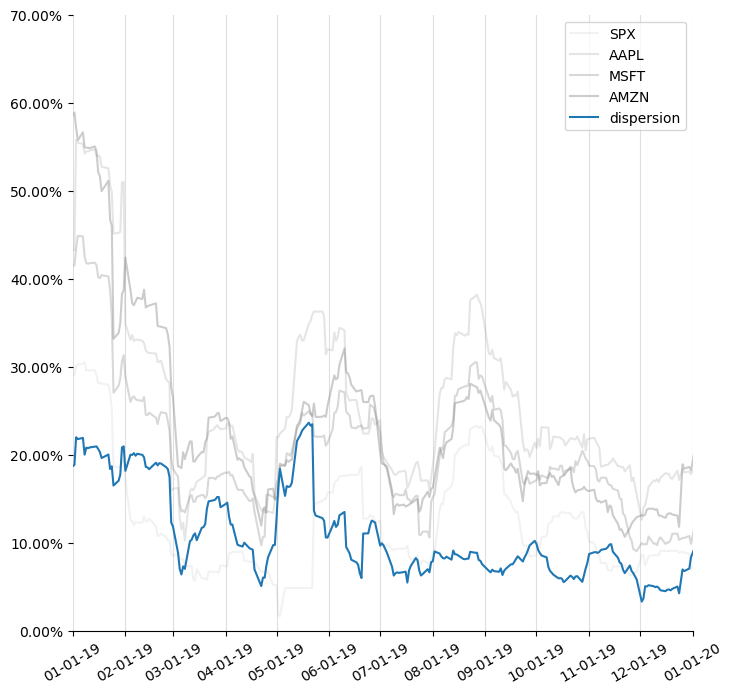

In [95]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import datetime
fig, ax1 = plt.subplots(figsize=(8, 8))

title="SPX Volatility"
subtitle="30, 60, 90, 120, 540 day implied volatilities and slopes"
col_count=0
for col in df_realized_vols.columns:
    if(col=="dispersion"):
        ax1.plot(df_realized_vols.index,df_realized_vols[col],label = f'{col}')
    else:
        col_count+=1
        ax1.plot(df_realized_vols.index,df_realized_vols[col],label = f'{col}',color='grey',alpha=0.1*col_count)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals = 2))
plt.ylim([0, .7])
plt.gca().spines[['left','right', 'top']].set_visible(False)

plt.grid(axis = 'x',alpha = 0.4)
plt.legend(loc = 'best',ncol = 1)
left=datetime.datetime(2019, 1, 1)
right=datetime.datetime(2020, 1, 1)

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y')) 

# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation = 30)  

# Changes x-axis range
plt.gca().set_xbound(left, right)



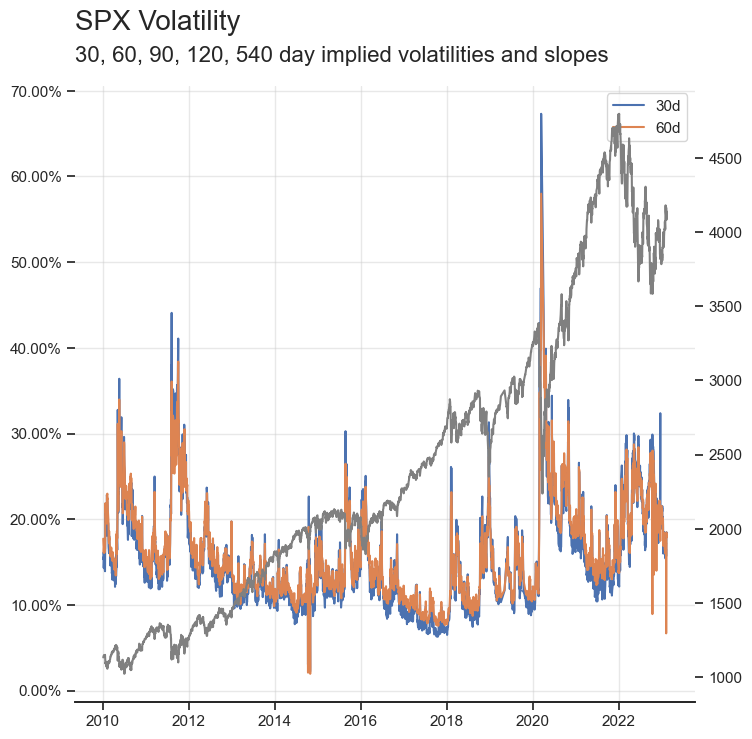

In [138]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots(figsize=(8, 8))

title="SPX Volatility"
subtitle="30, 60, 90, 120, 540 day implied volatilities and slopes"
    # add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.95,s = title,fontname = 'Arial',
    fontsize = 20,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.91,s = subtitle,fontname = 'Arial',
    fontsize = 16,ha = 'left',transform = fig.transFigure
)


ax1.plot(df.index,df['iv30']/100, label = '30d')
ax1.plot(df.index,df['iv60']/100, label = '60d')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals = 2))
plt.gca().spines[['left','right', 'top']].set_visible(False)

plt.grid(axis = 'both',alpha = 0.45)
plt.legend(loc = 'best',ncol = 1)
ax2 = ax1.twinx()
ax2.plot(df.index,df['stockpx'], color = 'grey', label='SPX')
plt.gca().spines[['left','right', 'top']].set_visible(False)
#


,align,choice,time,coherence,firing_rate
0,dots,T1,-80,0.0,33.189967
1,dots,T1,-80,3.2,31.691726
2,dots,T1,-80,6.4,34.279840
3,dots,T1,-80,12.8,32.631874
4,dots,T1,-80,25.6,35.060487
...,...,...,...,...,...
843,sacc,T2,300,3.2,33.281734
844,sacc,T2,300,6.4,27.583979
845,sacc,T2,300,12.8,28.511530
846,sacc,T2,300,25.6,27.009804


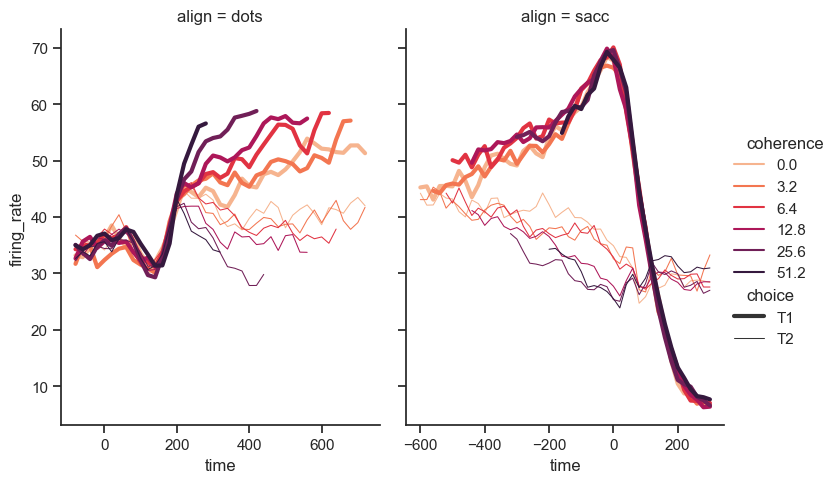

In [84]:
import seaborn as sns
sns.set_theme(style="ticks")

dots = sns.load_dataset("dots")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=dots,
    x="time", y="firing_rate",
    hue="coherence", size="choice", col="align",
    kind="line", size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)
dots


In [34]:
import re  
bla="blabla bla -pxstock"
print(re.sub("-pxstock", "", bla))
data2=data.copy()
data2.columns=[re.sub("OPT/", "", x) for x in data2.columns]
tickers

blabla bla 


['SPX', 'AAPL', 'MSFT', 'AMZN']